In [46]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import sys
import matplotlib.pyplot as plt

sys.path.insert(0, "..")


In [47]:
# Cargar el DataFrame desde el archivo JSON
df = pd.read_json('../data/processed/rgw_data.json', orient='records', lines=True)

# Convertir las listas de coordenadas en arrays numpy
df['cop_x'] = df['cop_x'].apply(lambda x: np.array(x))
df['cop_y'] = df['cop_y'].apply(lambda x: np.array(x))

# Combinar las columnas de coordenadas en una sola entrada
X_cop_x = np.array(df['cop_x'].tolist())
X_cop_y = np.array(df['cop_y'].tolist())
X = np.stack((X_cop_x, X_cop_y), axis=-1)

# Convertir las etiquetas a números
label_map = {'Healthy': 0, 'Diabetic': 1, 'Neuropathic': 2}
y = df['class'].map(label_map).values

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=40)
train_index, test_index = next(sss.split(X, y))
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

# Escalar los datos para mejorar el rendimiento del modelo
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 2)).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, 2)).reshape(X_test.shape)

# Verificar las dimensiones de los conjuntos de datos
print("Shape de X_train:", X_train_scaled.shape)
print("Shape de X_test:", X_test_scaled.shape)
print("Shape de y_train:", y_train.shape)
print("Shape de y_test:", y_test.shape)


Shape de X_train: (3360, 500, 2)
Shape de X_test: (1440, 500, 2)
Shape de y_train: (3360,)
Shape de y_test: (1440,)


In [48]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Definir el modelo de CNN para series de tiempo
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1:])),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Salida para 3 clases (Healthy, Diabetic, Neuropathic)
])

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Definir early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Ver resumen del modelo
model.summary()
model.save('CNN.h5')

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 498, 32)        │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 249, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 247, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 123, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 7872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │       503,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 510,499 (1.95 MB)

 Trainable params: 510,499 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Entrenar el modelo
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test))


Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4604 - loss: 1.0348 - val_accuracy: 0.6431 - val_loss: 0.8081
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6397 - loss: 0.8262 - val_accuracy: 0.6667 - val_loss: 0.7384
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6638 - loss: 0.7476 - val_accuracy: 0.6903 - val_loss: 0.7013
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7138 - loss: 0.6576 - val_accuracy: 0.7229 - val_loss: 0.6598
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7625 - loss: 0.5808 - val_accuracy: 0.7174 - val_loss: 0.6498
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7618 - loss: 0.5424 - val_accuracy: 0.7243 - val_loss: 0.6550
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7989 - loss: 0.4850 - val_accuracy: 0.7306 - val_loss: 0.6361
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8127 - loss: 0.4500 - 

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7746 - loss: 1.7019
Pérdida en el conjunto de prueba: 1.7250715494155884
Precisión en el conjunto de prueba: 0.7749999761581421


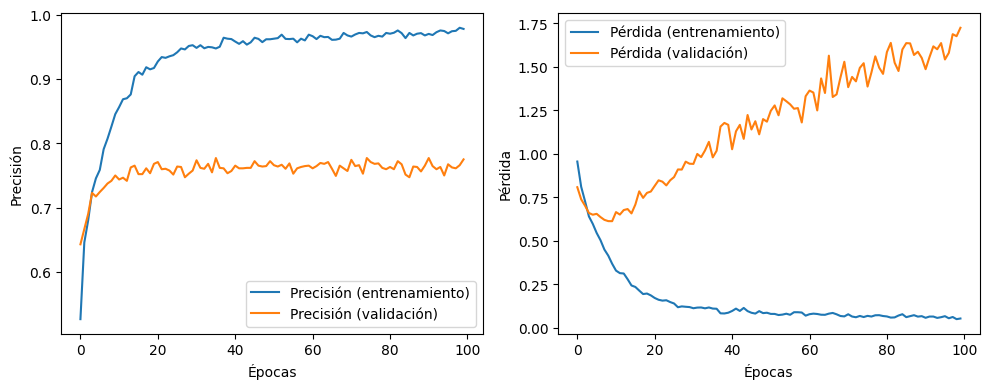

In [50]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Pérdida en el conjunto de prueba: {loss}")
print(f"Precisión en el conjunto de prueba: {accuracy}")

# Visualizar precisión y pérdida durante el entrenamiento
plt.figure(figsize=(10, 4))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión (entrenamiento)')
plt.plot(history.history['val_accuracy'], label='Precisión (validación)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida (entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida (validación)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


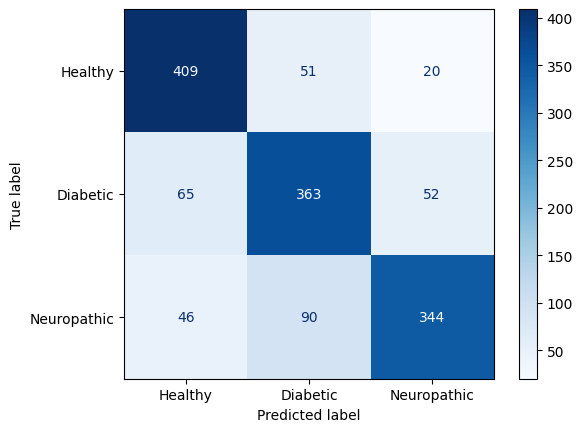

Accuracy: 0.775
Precision: 0.7778998778998779
F1 Score: 0.7745540069686412
Recall: 0.775
              precision    recall  f1-score   support

     Healthy       0.79      0.85      0.82       480
    Diabetic       0.72      0.76      0.74       480
 Neuropathic       0.83      0.72      0.77       480

    accuracy                           0.78      1440
   macro avg       0.78      0.78      0.77      1440
weighted avg       0.78      0.78      0.77      1440



In [51]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score, classification_report, ConfusionMatrixDisplay
# Realizar predicciones con el modelo entrenado
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Diabetic', 'Neuropathic'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Calcular y mostrar las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")

# Mostrar un informe de clasificación detallado
print(classification_report(y_test, y_pred_classes, target_names=['Healthy', 'Diabetic', 'Neuropathic']))
